# Permit-to-Occupancy in New York City

This notebook (along with files associated with it) examines the timeline of building construction to occupation in New York City.

## Introduction

### Construction Permit Process

Before a new building can begin construction it has to go through a long professional vetting process. The Department of Buildings (DOB) is the principal governmental organization responsible for overseeing the inspections and paperwork required for breaking ground. Once the construction permit has been issued and posted, work can begin.

### Certificate of Occupancy Process

The last step of new building construction is obtaining a certificate of occupancy ("C of O" for short). This document affirms that the building in question has been deemed to conform to the building code and is safe to occupy. 

A C of O is required for a building to be legally occupiable. DOB verifies with other coordinating agencies that all other outstanding requirements for the building have been satisfied before issuing the permit. Thus obtaining a C of O is the last step of the process in opening and occupying a building.

Most C of Os are permanent documents, however it is also possible to obtain an (expediated?) temporary document. Temporary C of Os have an expiration date, by which time a permanent document ought to have been granted. For our purposes we will treat them as equivalent documents.

### Retrieving Certificates of Occupancy

Certificates of Occupancy are publically available via the DOB [BIS interface](http://a810-bisweb.nyc.gov/bisweb/bsqpm01.jsp). This is an old interface and technically challenging to hook up to progammatically. Furthermore C of Os are stored as PDF documents, so access requires a pipeline for retrieving, loading, scanning, and parsing PDF text.

The `co_reader.py` module in this repository implements this capacity. For more technical notes on how that's done refer to that module's documentation.

### Retrieving Construction Permits

DOB releases a rolling list of all DOB construction permits filed as a publically accessible [dataset](https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a) on the New York City Open Data portal. Retrieving these permits is merely a matter of accessing, extracting, and filtering this dataset.

### Joining Permits to Certs

As expected, both the permits database and the certification pages are keyed by building `BIN`. However since the cert data requires a massive and long-running web scraping operation, the permit data is used as a base and the cert data is joined against it.

## Reading Construction Permit Data

The code below sets up our construction permit data.

In [1]:
import pandas as pd
import numpy as np
from __future__ import print_function

In [2]:
pd.set_option("max_columns", 500)

In [3]:
permits = pd.read_csv("DOB_Permit_Issuance.csv")

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,8,9,11,12,31,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
permits.sample(3)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate
553853,MANHATTAN,1031645,333,CENTRAL PARK WEST,122732506.0,1.0,A2,NaN,1207,29,107,10025,2,YES,NaN,NaN,MH,ISSUED,INITIAL,EW,1.0,MH,,NOT APPLICABLE,06/01/2016,06/14/2016 12:00:00 AM,01/14/2017,06/14/2016,GENCI,KONICA,G & G MECHANICAL GROUP,2126712241,GENERAL CONTRACTOR,0614544,,,,,,,,,CONDO/CO-OP,NaN,NA,MORGAN,HARTING,333,CENTRAL PARK WEST,NEW YORK,NY,10025,3475106964,06/15/2016 12:00:00 AM
7838,MANHATTAN,1017841,119,EAST 17 STREET,140077360.0,1.0,A3,Y,873,14,105,10003,1,YES,NaN,NaN,EQ,ISSUED,INITIAL,EQ,1.0,SF,,NaN,05/09/2013,05/09/2013 12:00:00 AM,05/09/2014,05/09/2013,CHRISTOPHER,DOWNES,EVEREST SCAFFOLDING INC,7183281004,GENERAL CONTRACTOR,0032158,,,,,,,,,PARTNERSHIP,NaN,GRAMERCY PALACE CORP,PAOLO,ZAMPOLLI,44,WALL STREET,NEW YORK,NY,10005,2122063700,05/10/2013 12:00:00 AM
241437,BROOKLYN,3127291,681,E 7TH ST,320328463.0,1.0,A2,NaN,5401,72,312,11218,1,YES,OP,NaN,PL,ISSUED,INITIAL,PL,1.0,,,NOT APPLICABLE,09/30/2014,09/30/2014 12:00:00 AM,09/30/2015,09/30/2014,JEFFREY,TROODLER,MILLENNIUM MECH CONT INC,7.18492e+09,MASTER PLUMBER,0000434,,,,,,,,,INDIVIDUAL,NaN,NA,CHAIM,GLICK,681,E 7TH ST,BROOKLYN,NY,11218,7188712958,10/01/2014 12:00:00 AM


Non-obvious column keys:

* Bin # &mdash; Building Identification Number
* Job # &mdash; The number assigned to the job in the DOB system.
* Job doc # &mdash; A single job, if the job is of a sufficient level of complexity, can have multiple permits associated with it (when this occurs is unclear to me, however).

  These documents are all (almost?) always approved at the same time, so for our purposes we may safely take only Job doc # == 1.
* Job Type &mdash; We want specifically records with `Job Type=NB` as these are new building construction jobs.
* Permit Type &mdash; We want specifically records with `NB`, again.
* Self_Cert &mdash; Whether or not the job was professionally certified (at the cost of the owner; expedites the approval process).
* Bldg Type &mdash; Unsure what this is, but it seems to be unimportant. Only options are 1, 2, and (occassionally) an empty string.
* Permit Status &mdash; Whether the permit has been issued (usually), re-issued (occassionally), or is in process of being issued (rare, temporal).

  This appears to mean specifically the physical documents.

  For our purposes we only want original issuances.
* Filing Status &mdash; Whether the permit filed is a renewal or an initial filing.

  This appears to mean the actual permit document.
  
  Obviously we only want initial filings.
* Permit Sequence # &mdash; the number of the permit, in terms of how many times it has been renewed or perhaps re-requested. As expected, 'Filing Status'=='INITAL' implies that 'Permit Sequent #' == 1.0.
* Permit Subtype &mdash; Unknown, may be [building type](http://www.parkeronline.org/DocumentCenter/View/16233). Mostly left empty regardless.
* Oil Gas &mdash; Always empty.
* Site Fill &mdash; Apparent dirt movage. Very important to our audience! Will investigate further along.
* Filing Date &mdash; Date that the permit was approved.
* Expiration Date &mdash; Exactly one year less a day from the filing date.

In [5]:
permits['Permit Status'].value_counts()

ISSUED        553319
RE-ISSUED       3245
IN PROCESS        53
Name: Permit Status, dtype: int64

In [6]:
permits['Filing Status'].value_counts()

INITIAL    380733
RENEWAL    175884
Name: Filing Status, dtype: int64

In [7]:
permits['Job doc. #'].value_counts()

1.0     499793
2.0      44227
3.0      10095
4.0       1653
5.0        608
6.0        140
7.0         62
8.0         27
9.0         10
10.0         2
Name: Job doc. #, dtype: int64

Applying the restrictions noted in our exploration of the dataset nets us our new building permits.

In [8]:
new_building_permits = permits[(permits['Job Type'] == 'NB') &
                               (permits['Permit Type'] == 'NB') &
                               (permits['Permit Status'] == 'ISSUED') & 
                               (permits['Filing Status'] == 'INITIAL') &
                               (permits['Job doc. #'] == 1.0)]

In [9]:
len(permits)

556644

In [10]:
len(new_building_permits)

6819

The trouble is that this set is still not fully de-duped.

These entries appear to be seperate filing, each of which resulted in a construction permit being granted!

In [11]:
from collections import Counter
from tqdm import tqdm

In [12]:
cnt = 0
for _bin in tqdm(set(new_building_permits['Bin #'])):
    if len(new_building_permits[new_building_permits['Bin #'] == _bin]) > 1:
        cnt += 1
print(cnt)

100%|██████████| 6136/6136 [00:10<00:00, 572.40it/s]

567


Our timeline will need to accomodate the possibility of multiple permits&mdash;as it turns out, it is possible for multiple initial new building construction permits, neither reissues (in case the first permit was lost) or renewals (in case the first permit expired), to be obtained. This occurs, we expect, when a building project is complex enough that the work involved invokes several distinct construction permits.

In [13]:
counter = Counter()
for _bin in tqdm(set(new_building_permits['Bin #'])):
    nbp_l = len(new_building_permits[new_building_permits['Bin #'] == _bin])
    if nbp_l > 1:
        counter[nbp_l] += 1
counter

100%|██████████| 6136/6136 [00:10<00:00, 604.78it/s]


Counter({2: 521, 3: 21, 4: 18, 5: 1, 6: 2, 8: 1, 13: 1, 17: 1, 18: 1})

This is 1250 jobs total, a *very* significant number that takes a big bite out of our 6-odd thousand total.

In [36]:
new_building_permits['Issuance Date'] = pd.to_datetime(new_building_permits['Issuance Date'])

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
s = dict()
for _bin in tqdm(set(new_building_permits['Bin #'])):
    bin_srs = new_building_permits[new_building_permits['Bin #'] == _bin]
    if len(bin_srs) > 1:
        s[_bin] = np.max(bin_srs['Issuance Date'].values) - np.min(bin_srs['Issuance Date'].values)

100%|██████████| 6136/6136 [00:13<00:00, 443.12it/s]


The number of new building construction lots with multiple initial permits:

In [62]:
len(s)

567

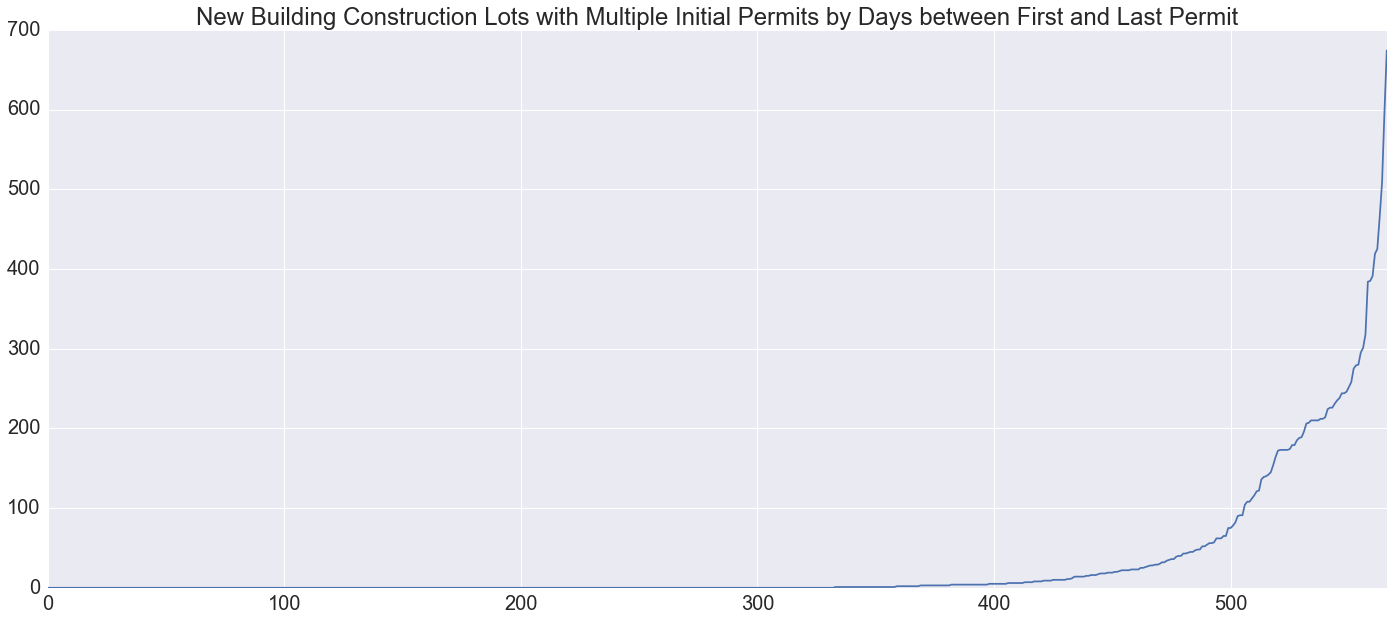

In [63]:
sns.set(font_scale=2)
pd.Series(s).sort_values().reset_index(drop=True).map(lambda s: s.days).plot(title='New Building Construction Lots with Multiple Initial Permits by Days between First and Last Permit', figsize=(24, 10))

How many of these lots had time delays between permit issuances? By how much?

In [92]:
len(s[s > timedelta(days=0)])

234

In [97]:
len(s[s > timedelta(days=180)])

39

In [98]:
len(s[s > timedelta(days=365)])

9

I begin to suspect that the high end of the time delays there are simply entirely new building construction jobs&mdash;cases perhaps where the first bid was scrapped completely and a new one was started, for whatever (disfunctional, likely) reason.

In [64]:
s = dict()
for _bin in tqdm(set(new_building_permits['Bin #'])):
    bin_srs = new_building_permits[new_building_permits['Bin #'] == _bin]
    s[_bin] = np.max(bin_srs['Issuance Date'].values) - np.min(bin_srs['Issuance Date'].values)

100%|██████████| 6136/6136 [00:14<00:00, 414.92it/s]


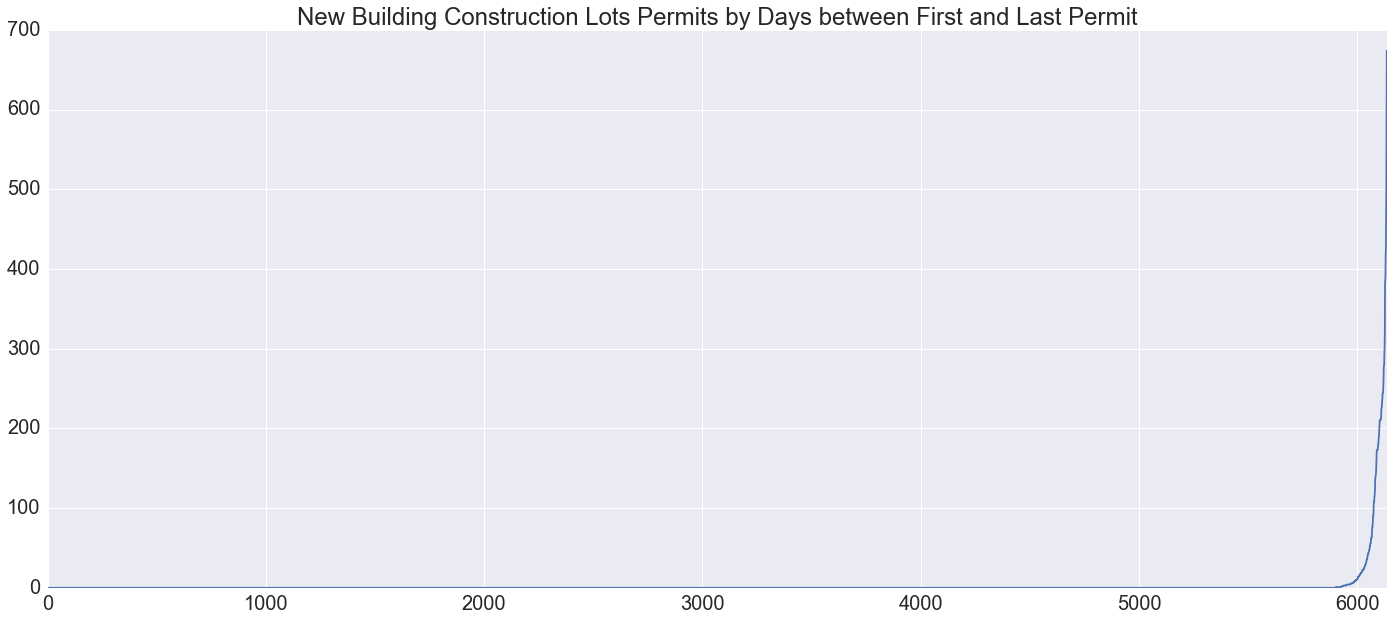

In [65]:
sns.set(font_scale=2)
pd.Series(s).sort_values().reset_index(drop=True).map(lambda s: s.days).plot(title='New Building Construction Lots Permits by Days between First and Last Permit', figsize=(24, 10))

These duplicitous permits are not helpful to us. Let's simply take the date of the earliest one, as even in the case of extreme time lag between the issuance of permits, the issuance of a certificate of occupancy is still the ultimate authority on a building opening.

In [14]:
import arrow

In [15]:
import time

In [16]:
def select_earliest_permit(df):
    return df.iloc[np.argmin(df['Filing Date'].apply(lambda x: arrow.get(x,"MM/DD/YYYY")).values)]

In [17]:
list_by_bin = []
for _bin in tqdm(set(new_building_permits['Bin #'])):
    df = new_building_permits[new_building_permits['Bin #'] == _bin]
    if len(df) > 1:
        # print(select_earliest_permit(df))
        list_by_bin.append(select_earliest_permit(df))
        # time.sleep(1)
    else:
        list_by_bin.append(df.iloc[0])

100%|██████████| 6136/6136 [00:12<00:00, 487.06it/s]


This step took a long time to figure out. By default it concats Series into one super-Series, but axis=1 puts things in the wrong place index-wise, so I have to swap the indexes with `T` (transpose).

In [18]:
deduped_new_building_permits = pd.concat(list_by_bin, axis=1).T

In [19]:
deduped_new_building_permits['BOROUGH'].value_counts()

QUEENS           1898
BROOKLYN         1890
STATEN ISLAND    1566
BRONX             486
MANHATTAN         296
Name: BOROUGH, dtype: int64

In [20]:
borough_map = {
    'BROOKLYN': 'B',
    'QUEENS': 'Q',
    'STATEN ISLAND': 'R',
    'BRONX': 'X',
    'MANHATTAN': 'M'
}

In [21]:
deduped_new_building_permits.head(5)['Bin #']

26416         2818049
168380        4292627
131159        3833881
535342    2.09719e+06
544547        5144619
Name: Bin #, dtype: object

In [27]:
deduped_new_building_permits.head(1)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate
26416,BRONX,2818049,92,WEST TREMONT AVE,2.20177e+08,1,NB,NaN,2867,125,205,10453,2,YES,NaN,NaN,,ISSUED,INITIAL,NB,1,,,ON-SITE,06/21/2013,06/21/2013 12:00:00 AM,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038,2128637490,06/22/2013 12:00:00 AM


## Reading Certificate of Occupation Data&mdash;August 2013 Test Run

In order to validate assumptions about the data pipeline I used (arbitrarily selected) August 2013 permits as a month of interest.

In [23]:
import co_reader

In [24]:
august_2013_permits = deduped_new_building_permits[deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").month == 9 and arrow.get(x,"MM/DD/YYYY").year == 2013)]

In [25]:
len(august_2013_permits)

186

In [26]:
c_of_o_dict = dict()
counter = 0
for ind in tqdm((august_2013_permits).iterrows()):
    print("On loop {0}...".format(counter + 1))
    boro = ind[1]['BOROUGH']
    bin = ind[1]['Bin #']
    boro_code = borough_map[boro]
    c_of_o_dict[bin] = co_reader.get_co_date(bin, boro_code)
    counter += 1

0it [00:00, ?it/s]

On loop 1...
Requested BIN 4162303 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000214797.PDF...
PDF Certificate of Occupancy 'Q000214797.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000085427.PDF...
PDF Certificate of Occupancy 'Q000085427.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420825673.PDF...
PDF Certificate of Occupancy '420825673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420825263.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420825263.PDF' again in five seconds...


1it [00:27, 27.16s/it]

After some delay, PDF Certificate of Occupancy '420825263.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 2...
Requested BIN 1082214 data from BIS, awaiting response...


2it [00:39, 22.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 3...
Requested BIN 5047261 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147984F.PDF...
PDF Certificate of Occupancy '520147984F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


3it [00:51, 19.61s/it]

['04/15/2015']
Date(s) found!
On loop 4...
Requested BIN 2000570 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 220192887F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220192887F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220192887F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/07/2015']
Date(s) found!
Scanning 220192887T002.PDF...
PDF Certificate of Occupancy '220192887T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/08/2014', '03/08/2015']
Date(s) found!
Scanning 220192887.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220192887.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220192887.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/07/2015']
Date(s) found!
Scanni

4it [01:18, 21.74s/it]

['03/09/2015', '06/07/2015']
Date(s) found!
On loop 5...
Requested BIN 4163416 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000115527.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000115527.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000115527.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420849336T1.PDF...
PDF Certificate of Occupancy '420849336T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/17/2015', '10/15/2015']
Date(s) found!
Scanning 420849345F.PDF...
PDF Certificate of Occupancy '420849345F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


5it [01:43, 22.76s/it]

['07/14/2015']
Date(s) found!
On loop 6...
Requested BIN 2829340 data from BIS, awaiting response...


6it [01:54, 19.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 7...
Requested BIN 4163841 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420861482F.PDF...
PDF Certificate of Occupancy '420861482F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2015']
Date(s) found!
Scanning 420861491.PDF...
PDF Certificate of Occupancy '420861491.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


7it [02:07, 17.31s/it]

['04/15/2015']
Date(s) found!
On loop 8...
Requested BIN 3410228 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320719585.PDF...
PDF Certificate of Occupancy '320719585.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


8it [02:19, 15.62s/it]

['09/09/2015']
Date(s) found!
On loop 9...
Requested BIN 4000093 data from BIS, awaiting response...


9it [02:29, 14.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 10...
Requested BIN 2829381 data from BIS, awaiting response...


10it [02:40, 13.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 11...
Requested BIN 1085940 data from BIS, awaiting response...


11it [02:51, 12.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 12...
Requested BIN 3807374 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000000790.PDF...
PDF Certificate of Occupancy 'B000000790.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320491115.PDF...
PDF Certificate of Occupancy '320491115.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


12it [03:06, 13.30s/it]

['05/20/2016']
Date(s) found!
On loop 13...
Requested BIN 4101093 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000152898.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000152898.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000152898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420856229.PDF...


13it [03:39, 19.27s/it]

PDF Certificate of Occupancy '420856229.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 14...
Requested BIN 4134801 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420629270F.PDF...
PDF Certificate of Occupancy '420629270F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/13/2015']
Date(s) found!
Scanning 420814596F.PDF...
PDF Certificate of Occupancy '420814596F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


14it [03:54, 17.99s/it]

['11/06/2015']
Date(s) found!
On loop 15...
Requested BIN 5861035 data from BIS, awaiting response...


15it [04:05, 15.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 16...
Requested BIN 4593965 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420821025F.PDF...
PDF Certificate of Occupancy '420821025F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


16it [04:17, 14.66s/it]

['04/25/2014']
Date(s) found!
On loop 17...
Requested BIN 4004803 data from BIS, awaiting response...


17it [04:28, 13.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 18...
Requested BIN 4004953 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000029501.PDF...
PDF Certificate of Occupancy 'Q000029501.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000168574.PDF...


18it [04:41, 13.28s/it]

PDF Certificate of Occupancy 'Q000168574.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 19...
Requested BIN 1088829 data from BIS, awaiting response...


19it [04:51, 12.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 20...
Requested BIN 4529910 data from BIS, awaiting response...


20it [05:02, 11.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 21...
Requested BIN 1089321 data from BIS, awaiting response...


21it [05:13, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 22...
Requested BIN 4464467 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420887927.PDF...


22it [05:25, 11.80s/it]

PDF Certificate of Occupancy '420887927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 23...
Requested BIN 3088244 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning B000218282.PDF...
PDF Certificate of Occupancy 'B000218282.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000121583.PDF...
PDF Certificate of Occupancy 'B000121583.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000204812.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000204812.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000204812.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000225

ConnectionError: HTTPConnectionPool(host='a810-bisweb.nyc.gov', port=80): Max retries exceeded with url: /bisweb/CofoDocumentContentServlet?passjobnumber=null&cofomatadata1=cofo&cofomatadata2=B&cofomatadata3=300&cofomatadata4=768000&cofomatadata5=300768916F.PDF&requestid=5 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x10cf1fe10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [ ]:
c_of_o_dict

In [ ]:
len([date for (bin, date) in c_of_o_dict.items() if date != None])

### Data validation check

186 new building construction permits were issued in August 2013. As of late June 2016, 85 of these have corresponding certificates of occupancy on record. This correspondgs with a `85/186 = ~45%` completion rate.

85*12=1020, so this data implies that in New York City there are around 2000 new building construction permits are issued per year, of which 1000 new buildings are completed per year.

Is this figure reasonable? [According to the DOB component of the Mayor's Management Report](http://www1.nyc.gov/assets/operations/downloads/pdf/pmmr2016/dob.pdf), a typical financial year in New York City sees the issuance of approximately 5,500 certificates of occupancy. This implies that approximately one in five certificates issued are for new buildings, while the remaining four in five certificates issued are for significantly renovated existing ones.

As a gut check, this seems reasonable.

### Notes on the algorithm

As expected this process of mining PDF pages is fairly slow. Still, the algorithm ran faster than expected, generating 186 results in 48 minutes, 46 seconds.

This corresponds to an average runtime of approximately 16 seconds per bin.

Fast failures occur in approximately 12 seconds. Documents with many documents to scan take approximately 20 seconds. 

Hitting a wait page extends the wait time 5 seconds apiece.

The worst case response took 32 seconds. The best case response took 10.

The full dataset contains 6136 bins, corresponding with a runtime of approximately 27.3 hours. A conversation must be had to verify that such a thing is necessary before a pull of such a magnitude be attempted.

In [ ]:
sample['Bin #'].map(lambda x: c_of_o_dict[x]).values[0]

In [ ]:
sample = august_2013_permits.copy()
sample['Certificate Date'] = sample['Bin #'].map(lambda x: c_of_o_dict[x]).values
sample['Filing Date'] = sample['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
sample['Build Time'] = sample.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')

### Sample analysis

Our initial sample is of a very small sample size, but it's still useful to see a few quick things.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pier = sample['Build Time'].map(lambda v: pd.isnull(v)).value_counts()
pier.index = ['Built', 'Not Built']
pier.name = ''

#### August 2013&mdash;June 2016 newly permitted construction completion rate

What percentage of construction permits issued in August of 2013 resulted in completed buildings as of today?

In [ ]:
pier.plot(kind='pie', figsize=(8,8), fontsize=20, colors=('lightgreen', 'lightcoral')) # title='August 2013 Newly Permitted Construction')

#### August 2013&mdash;June 2016 newly permitted construction completion times

When did buildings with construction permits issued in August of 2013 actually complete?

In [ ]:
sns.set_style('white')
sns.distplot(sample['Build Time'][sample['Build Time'].notnull()].map(lambda t: t.days),
             bins=10,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

The lack of a discernable pattern in this data is surprising, but may simply be the result of a small sample size (with 86 data point in 10 bins, there are just 8.6 observations per bin). To take this further, a larger sample or a full run must be taken.

#### Archiving the data

In [ ]:
deduped_new_building_permits.to_csv("new_building_permits.csv")
sample.to_csv("august_2013_sample.csv")

## Briefly&mdash;Site Fill

The following data looks interesting. Perhaps it should be the target of further analysis?

In [135]:
deduped_new_building_permits['Site Fill'].value_counts()

ON-SITE                                     3615
USE UNDER 300 CU.YD                         1805
OFF-SITE                                     701
NONE                                          15
Name: Site Fill, dtype: int64

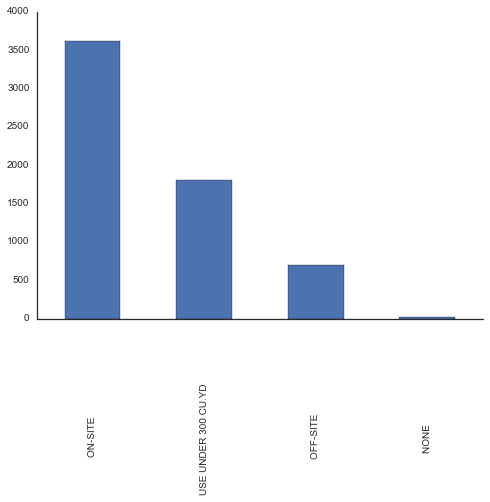

In [138]:
deduped_new_building_permits['Site Fill'].value_counts().plot(kind='bar')
sns.despine()

## Reading Certificate of Occupation Data&mdash;Partial Run

The full algorithm takes over a day to run, so I broke it up into intermediate nightly steps.

The run was ammended into a partial one partway through.

### Briefly&mdash;Examining Yearly Counts

In [1]:
import pandas as pd
import seaborn as sns
import arrow
%matplotlib inline

In [2]:
deduped_new_building_permits = pd.read_csv("new_building_permits.csv")

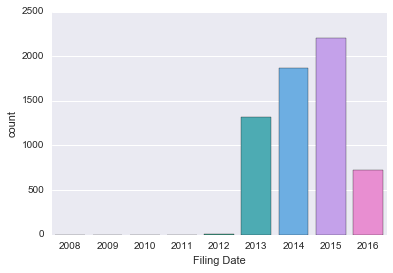

In [9]:
years = deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").year)
sns.countplot(years)

In [7]:
deduped_new_building_permits['Year'] = deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").year)

In [7]:
deduped_new_building_permits[deduped_new_building_permits['Year'] == 2008]

,Unnamed: 0,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,...,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year
4078,336988,BROOKLYN,3855241.0,12749,FLATLANDS AVENUE,302322948.0,1.0,NB,Y,4566.0,...,JOHN,O'CONNELL,85-25,68 ROAD,REGO PARK,NY,11374.0,9.175778e+09,04/30/2015 12:00:00 AM,2008


This entry exhibits that the leading years in the dataset are for permits which had an extremely long lag time between filing and issuance, for unknown reasons.

### Algorithm

In [3]:
from tqdm import tqdm
import numpy as np
import co_reader

In [4]:
def co_run(df):
    borough_map = {
        'BROOKLYN': 'B',
        'QUEENS': 'Q',
        'STATEN ISLAND': 'R',
        'BRONX': 'X',
        'MANHATTAN': 'M'
    }
    c_of_o_dict = dict()
    counter = 0
    for ind in tqdm((df).iterrows()):
        print("On loop {0}...".format(counter + 1))
        boro = ind[1]['BOROUGH']
        bin = ind[1]['Bin #']
        boro_code = borough_map[boro]
        c_of_o_dict[bin] = co_reader.get_co_date(bin, boro_code)
        counter += 1
    sample = df.copy()
    sample['Certificate Date'] = sample['Bin #'].map(lambda x: c_of_o_dict[x]).values
    sample['Filing Date'] = sample['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
    sample['Build Time'] = sample.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')
    return sample

In [17]:
# test_run_result = co_run(permits_2008_to_2013.sample(2))

In [18]:
# test_run_result

### Diversion&mdash;`co_reader` Redesign

When I ran the `co_reader` algorithm on the test set it exhibited one kind of behavior. When I ran it again a week later on the real thing, with an estimated leg time of 6 hours for the first set (permits issued prior to 2013), it exhibited another entirely.

The issue&mdash;which appeared to be present at the time of the previous run as well&mdash;is that the `subprocess.Popen` calls that I make inside of my code spawn `python2.7` child processes, which in turn spawn `tesseract` child processes. These processes finish their actual jobs very quickly, as expected, but do not finish running very quickly, hanging around instead as [zombie processes](https://en.wikipedia.org/wiki/Zombie_process).

Waiting for them to quit using `Popen.wait` forces wait times in excess of two minutes per document, a completely unacceptable state of affairs. If I were to run the entire dataset through at that speed I could expect a month's wait for it to finish executing!

The only way to force these threads to die, really die, if we do not wait for them explicitly, is to restart the entire computer. No program or Python module can force them to quit because they can only be killed by killing their live root parent, and their live root parent is the original Python execution&mdash;this notebook's process. In other words the only way to kill the zombie army is to terminate the executing notebook's own kernel!

The test run appears to have been successful only because the number of subprocesses spawned did not exceed my computer's inherent thread limit, due to the small size of the sample.

Amazingly, however, another thing also seems to have changed. The original implementation of the algorithm required running the PDFs through an OCR processer because the files themselves were read-locked. However, when the algo is run again a week later it appears that the read-locking has been removed.

Thus I can avoid all of the issues above by simply not using OCR in the first place.

It's all very strange. But it works.

In [8]:
permits_2008_to_2013 = deduped_new_building_permits[deduped_new_building_permits['Year'] <= 2013]
permits_2014 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2014]
permits_2015 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2015]
permits_2016 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2016]

In [13]:
len(permits_2008_to_2013), len(permits_2014), len(permits_2015), len(permits_2016)

(1332, 1869, 2207, 728)

### Leg 1&mdash;2008 to 2013

This leg was successfully run overnight on July 2/3, 2016.

In [ ]:
leg_2008_to_2013 = co_run(permits_2008_to_2013)

(Note that this code logged its actuals inline with the notebook just as the August 2013 sample run did above, but the contents of that log have been removed from this notebook because loading so many lines of text was causing the notebook server to run very slowly.)

### Leg 2—2014

This leg was mostly run through during July 3, 2016 daylight hours. It failed on the ~1500th entry with a connection reset error, almost certainly due to a random Python bug.

(Note that this code logged its actuals inline with the notebook just as the August 2013 sample run did above, but the contents of that log have been removed from this notebook because loading so many lines of text was causing the notebook server to run very slowly.)

In [9]:
leg_2014_remaining = co_run(permits_2014_remaining)

0it [00:00, ?it/s]

#### Recovering data

There are over 1500 data points that were lost when the runner crashed. I didn't use an intermediary object like I did with the August 2013 test set, so I didn't cache the result. But the log file (removed from here per the above; output saved to `crashed_2014_log.txt`) is pretty extensive and completely standardized, so it should be fairly easy to extract the results thus far from there.

In [2]:
len(results)

1563

In [ ]:
results = dict()
BIN = None
dates = []

with open("crashed_2014_log.txt") as logfile:
    for line in logfile:
        if "Requested BIN" in line:
            # Calculate maximum minimum date and append.
            if dates:
                mindate = np.max(dates)
            else:
                mindate = None
            results[BIN] = mindate
            # Clean up.
            BIN = int(float(line.split(' ')[2]))
            dates = []
        elif "['" in line:
            date_strs = re.findall("[0-9]{2}[/][0-9]{2}[/][0-9]{4}", line)
            dates.append(min([arrow.get(date_str, 'MM/DD/YYYY') for date_str in date_strs]).datetime)

In [ ]:
permits_2014_partial = permits_2014[permits_2014['Bin #'].isin(results.keys())]
permits_2014_partial['Certificate Date'] = permits_2014_partial['Bin #'].map(lambda x: results[x]).values
permits_2014_partial['Filing Date'] = permits_2014_partial['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
permits_2014_partial['Build Time'] = permits_2014_partial.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')

In [48]:
leg_2014 = pd.concat([leg_2014_remaining, permits_2014_partial])

In [49]:
leg_2014.to_csv("leg_2014.csv")

#### Remaining workload

We need just under 300 (about 1 1/2 the size of the August 2013 test set) more queries to complete the 2014 recordset.

In [ ]:
permits_2014_remaining = permits_2014[~permits_2014['Bin #'].isin(permits_2014_partial['Bin #'])]

In [3]:
len(permits_2014_remaining)

292

In [ ]:
leg_2014_remaining = co_run(permits_2014_remaining)

Success!

In [ ]:
leg_2014 = pd.concat([leg_2014_remaining, permits_2014_partial])

In [ ]:
permits_sample = pd.concat([leg_2008_to_2013, leg_2014])

In [52]:
len(permits_sample)

3201

In [53]:
permits_sample.to_csv("permit_occupancy_join_sample.csv")

### Leg 3&mdash;2015

I will defer on further BISweb queries as I believe that this sample size is adequate, and because of the constrained timelines the data becomes increasingly less informative as we go on.

We can simulate percentage completion rates for recent construction ourselves.

### Leg 4&mdash;2016

Deferred; unlikely to be of much use anyway.

## Quick Peek

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
permits_sample = pd.read_csv("permit_occupancy_join_sample.csv")

In [58]:
full_pier = permits_sample['Build Time'].map(lambda v: pd.isnull(v)).value_counts()
full_pier.index = ['Built', 'Not Built']
full_pier.name = ''

In [62]:
full_pier / full_pier.sum()

Built        0.564823
Not Built    0.435177
Name: , dtype: float64

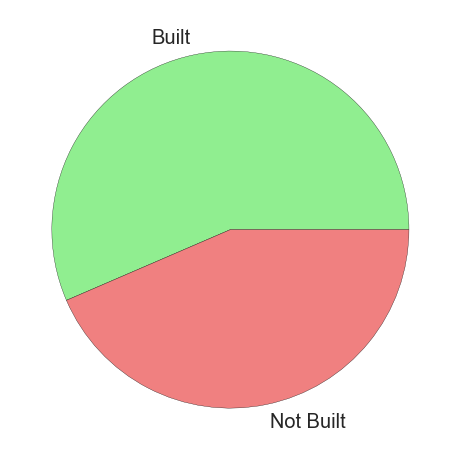

In [59]:
full_pier.plot(kind='pie', figsize=(8,8), fontsize=20, colors=('lightgreen', 'lightcoral')) # title='August 2013 Newly Permitted Construction')

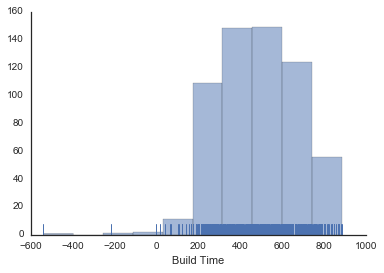

In [44]:
sns.set_style('white')
sns.distplot(permits_2014_partial['Build Time'][permits_2014_partial['Build Time'].notnull()].map(lambda t: t.days),
             bins=10,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()